In [79]:
"""
An example of using TensorFlow for building a regression model is given here. A class is defined that imports the data and train/test them on a simple regression model.
Data set 'house_pricing.csv' is used in the example to demonstrate the regression model.
"""

"\nAn example of using TensorFlow for building a regression model is given here. A class is defined that imports the data and train/test them on a simple regression model.\nData set 'house_pricing.csv' is used in the example to demonstrate the regression model.\n"

In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import seaborn as sns

tf.test.is_gpu_available()

True

In [81]:
class SimpleRegressionModel:
    """
    SimpleRegressionModel trains and tests a regression model using the given data frame.
    """
    def __init__(self):
        self.num_input = None
        self.num_output = None
        self.scalar = None
        self.num_training = None
        self.X_train = None
        self.Y_train = None
        self.num_validation = None
        self.X_val = None
        self.Y_val = None
        self.history = None
        self.num_test = None
        self.X_test = None
        self.Y_test = None
        self.model = None
    def import_dataset(self, df_total: pd.DataFrame, iplist: list, oplist: list, validation_size: float, test_size: float):
        total_X = df_total[df_total.columns.intersection(iplist)]
        object_columns = total_X.select_dtypes(include=['object'])
        if not object_columns.empty:
            dummy_columns = pd.get_dummies(object_columns)
            total_X = pd.concat([total_X.drop(object_columns, axis=1), dummy_columns], axis=1)
        self.num_input = len(total_X.columns)
        total_Y = df_total[df_total.columns.intersection(oplist)]
        self.num_output = len(total_Y.columns)
        train_val_X, self.X_test, train_val_Y, self.Y_test = train_test_split(total_X, total_Y, test_size=test_size, random_state=None)
        self.num_test = len(self.X_test.index)
        if validation_size == 0:
            self.X_train = train_val_X
            self.Y_train = train_val_Y
            self.X_val = []
            self.Y_val = []
            self.num_training = len(self.X_train.index)
            self.num_validation = 0
        else:
            self.X_train, self.X_val, self.Y_train, self.Y_val = train_test_split(train_val_X, train_val_Y, test_size=validation_size/(1-test_size), random_state=None)
            self.num_training = len(self.X_train.index)
            self.num_validation = len(self.X_val.index)
        print("Dataset size: training: {}, validation: {}, test: {}".format(self.num_training, self.num_validation, self.num_test))
        self.scalar = MinMaxScaler()
        self.X_train = self.scalar.fit_transform(self.X_train)
        if validation_size == 0:
            pass
        else:
            self.X_val = self.scalar.transform(self.X_val)
        self.X_test = self.scalar.transform(self.X_test)
    def design_model(self, hidden_layer_model: list, optimizer: str, learning_rate: float, loss: str):
        """
        The input model describes the design of the model. It is a list of layers. Each layer is given by a dictionary describing layer type, number of nodes, etc.
        """
        self.model = tf.keras.Sequential()
        for ind in range(len(hidden_layer_model)):
            if ind == 0:
                if hidden_layer_model[ind]["type"] == "dense":
                    layer = tf.keras.layers.Dense(hidden_layer_model[ind]["node"], activation = hidden_layer_model[ind]["activation"], input_shape = (self.num_input, ))
                else:
                    pass
            else:
                if hidden_layer_model[ind]["type"] == "dense":
                    layer = tf.keras.layers.Dense(hidden_layer_model[ind]["node"], activation = hidden_layer_model[ind]["activation"])
                else:
                    pass
            self.model.add(layer)
        self.model.add(
            tf.keras.layers.Dense(self.num_output)
        )
        self.model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    def train_model(self, epochs: int, batch_size: int):
        self.history = self.model.fit(self.X_train, self.Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=2)
        df_history = pd.DataFrame(self.history.history)
        df_history.plot()
    def evaluate_model(self):
        if self.num_validation == 0:
            print("Validation set is empty.")
        else:
            loss, mae = self.model.evaluate(self.X_val, self.Y_val, verbose=2)
            print("Validation set test result: loss={}, mae={}".format(loss, mae))
    def test_model(self):
        loss, mae = self.model.evaluate(self.X_test, self.Y_test, verbose=2)
        print("Test set test result: loss={}, mae={}".format(loss, mae))

In [89]:
df_house_pricing = pd.read_csv("house_pricing.csv").dropna()
print(df_house_pricing.head())

                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   
5  2014-05-02 00:00:00   490000.0       2.0       1.00          880      6380   
6  2014-05-02 00:00:00   335000.0       2.0       2.00         1350      2560   
7  2014-05-02 00:00:00   482000.0       4.0       2.50         2710     35868   
8  2014-05-02 00:00:00   452500.0       3.0       2.50         2430     88426   
9  2014-05-02 00:00:00   640000.0       4.0       2.00         1520      6200   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0  

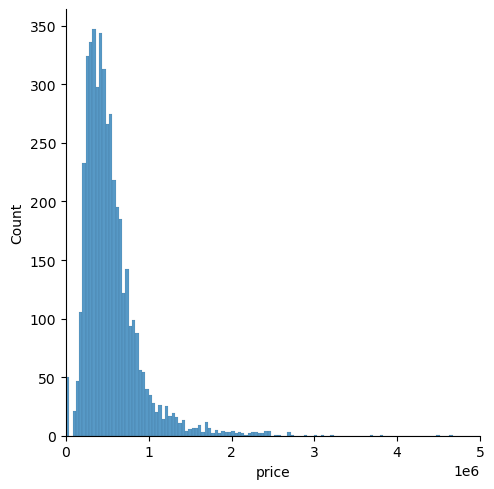

In [94]:
g = sns.displot(df_house_pricing['price'])
g.set(xlim=(0, 5e6))

In [ ]:
df_house_pricing = df_house_pricing[df_house_pricing['Price']<3e6]

In [83]:
srm = SimpleRegressionModel()
srm.import_dataset(
    df_total=df_house_pricing,
    iplist=["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", "sqft_above", "sqft_basement", "yr_built", "yr_renovated", "condition", "city"],
    oplist=["price"],
    validation_size=0, test_size=0.2)

Dataset size: training: 3680, validation: 0, test: 920


In [84]:
hidden_layer_model = [
    {
        "type": "dense",
        "node": 128,
        "activation": "relu"
    },
    {
        "type": "dense",
        "node": 64,
        "activation": "relu"
    },
    {
        "type": "dense",
        "node": 32,
        "activation": "relu"
    },
    {
        "type": "dense",
        "node": 32,
        "activation": "relu"
    },
    {
        "type": "dense",
        "node": 32,
        "activation": "relu"
    },
    {
        "type": "dense",
        "node": 16,
        "activation": "relu"
    },
    {
        "type": "dense",
        "node": 8,
        "activation": "relu"
    },
]
srm.design_model(hidden_layer_model=hidden_layer_model, optimizer='rmsprop', learning_rate=0.001, loss='mse')

Train on 2944 samples, validate on 736 samples
Epoch 1/200
2944/2944 - 0s - loss: 421545624264.3478 - mean_absolute_error: 542250.6875 - val_loss: 1691374874445.9131 - val_mean_absolute_error: 613996.3125
Epoch 2/200
2944/2944 - 0s - loss: 421544089867.1304 - mean_absolute_error: 542249.3125 - val_loss: 1691369560331.1304 - val_mean_absolute_error: 613992.1250
Epoch 3/200
2944/2944 - 0s - loss: 421529854308.1739 - mean_absolute_error: 542237.1250 - val_loss: 1691330307116.5217 - val_mean_absolute_error: 613962.4375
Epoch 4/200
2944/2944 - 0s - loss: 421462728347.8261 - mean_absolute_error: 542178.6250 - val_loss: 1691186854511.3044 - val_mean_absolute_error: 613853.6250
Epoch 5/200
2944/2944 - 0s - loss: 421252061451.1304 - mean_absolute_error: 541995.3125 - val_loss: 1690790261982.6086 - val_mean_absolute_error: 613552.1875
Epoch 6/200
2944/2944 - 0s - loss: 420723804249.0435 - mean_absolute_error: 541539.6875 - val_loss: 1689861887554.7827 - val_mean_absolute_error: 612846.2500
Epoch

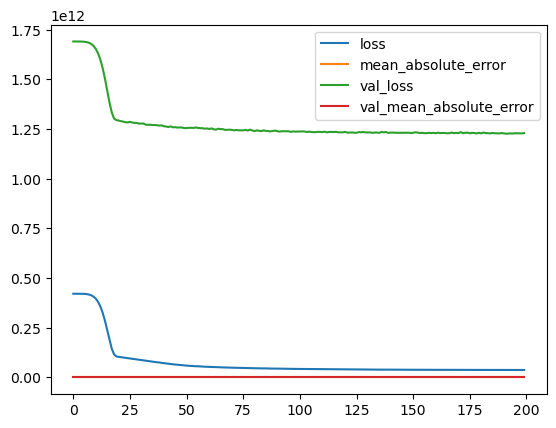

In [85]:
srm.train_model(epochs=200, batch_size=256)

In [86]:
srm.evaluate_model()

Validation set is empty.


In [87]:
srm.test_model()

920/920 - 0s - loss: 51535387176.0696 - mean_absolute_error: 120137.4531
Test set test result: loss=51535387176.069565, mae=120137.453125
